# **1) Installing Libraries**

In [ ]:
!pip install torch torchvision torchaudio numpy

# **2) Importing Datasets**

In [1]:
# Downloading the EMNIST dataset and using the digits split
from torchvision.datasets import EMNIST
from torchvision import transforms

train_data = EMNIST(root="./root", split="digits", train=True, download=True, transform=transforms.ToTensor())
test_data = EMNIST(root="./root", split="digits", train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 561753746/561753746 [00:15<00:00, 37252802.28it/s]


Extracting ./root/EMNIST/raw/gzip.zip to ./root/EMNIST/raw


In [2]:
# Creating validation set from training set
from torch.utils.data import random_split

TRAIN_SIZE = 0.85

train_size = int(TRAIN_SIZE * len(train_data))
val_size = len(train_data) - train_size

train_data, val_data = random_split(train_data, [train_size, val_size])

In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# **3) Implementing Model**

In [8]:
import torch

class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(num_features, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.layers(x)
        return logits

# **4) Training Loop**

In [5]:
# Utility function to compute accuracy whenever required
def compute_accuracy(model, data_loader):
    model = model.eval()
    correct = 0.0
    total = 0.0
    for idx, (features, labels) in enumerate(data_loader):
        with torch.inference_mode():
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)
        comparision = predictions == labels
        correct += torch.sum(comparision)
        total += len(comparision)

    return correct / total

In [9]:
# Training model
import torch.nn.functional as F

EPOCHS = 7
LEARNING_RATE = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiLayerPerceptron(num_features=784, num_classes=10)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

losses = []
train_accuracies, val_accuracies = [], []

for epoch in range(1, EPOCHS + 1):
    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        logits = model(features)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            print(f"Epoch: {epoch:03d}/{EPOCHS:03d} | Batch: {batch_idx+1:03d}/{len(train_loader):03d} | Loss: {loss:.2f}")

        losses.append(loss.item())

    train_accuracy = compute_accuracy(model, train_loader)
    val_accuracy = compute_accuracy(model, val_loader)

    print(f"\nTrain Accuracy: {train_accuracy * 100:.2f} | Val Accuracy: {val_accuracy * 100:.2f}\n")

    train_accuracies.append(train_accuracy.to('cpu'))
    val_accuracies.append(val_accuracy.to('cpu'))

Epoch: 001/007 | Batch: 001/3188 | Loss: 2.31
Epoch: 001/007 | Batch: 501/3188 | Loss: 2.27
Epoch: 001/007 | Batch: 1001/3188 | Loss: 1.91
Epoch: 001/007 | Batch: 1501/3188 | Loss: 0.99
Epoch: 001/007 | Batch: 2001/3188 | Loss: 0.44
Epoch: 001/007 | Batch: 2501/3188 | Loss: 0.56
Epoch: 001/007 | Batch: 3001/3188 | Loss: 0.31

Train Accuracy: 90.03 | Val Accuracy: 90.18

Epoch: 002/007 | Batch: 001/3188 | Loss: 0.16
Epoch: 002/007 | Batch: 501/3188 | Loss: 0.38
Epoch: 002/007 | Batch: 1001/3188 | Loss: 0.33
Epoch: 002/007 | Batch: 1501/3188 | Loss: 0.24
Epoch: 002/007 | Batch: 2001/3188 | Loss: 0.18
Epoch: 002/007 | Batch: 2501/3188 | Loss: 0.20
Epoch: 002/007 | Batch: 3001/3188 | Loss: 0.31

Train Accuracy: 93.62 | Val Accuracy: 93.71

Epoch: 003/007 | Batch: 001/3188 | Loss: 0.31
Epoch: 003/007 | Batch: 501/3188 | Loss: 0.37
Epoch: 003/007 | Batch: 1001/3188 | Loss: 0.28
Epoch: 003/007 | Batch: 1501/3188 | Loss: 0.07
Epoch: 003/007 | Batch: 2001/3188 | Loss: 0.20
Epoch: 003/007 | Batc

In [11]:
# Test Accuracy
test_acc = compute_accuracy(model.to(DEVICE), test_loader).item()
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 97.43%


# **5) Visualizing Metrics (Loss, Accuracy)**

In [6]:
# Plotting Helper
!curl "https://raw.githubusercontent.com/Lightning-AI/dl-fundamentals/main/unit04-multilayer-nets/4.3-mlp-pytorch/4.3-mlp-pytorch-part3-5-mnist/helper_plotting.py" -o helper_plotting.py
from helper_plotting import plot_training_loss, plot_accuracy, show_examples

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4013  100  4013    0     0  12596      0 --:--:-- --:--:-- --:--:-- 12619


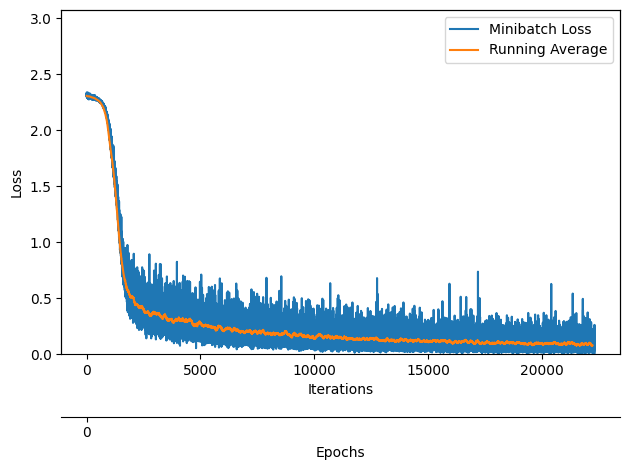

In [12]:
# Plotting Loss
plot_training_loss(minibatch_loss_list=losses, num_epochs=EPOCHS, iter_per_epoch=len(losses)//EPOCHS)

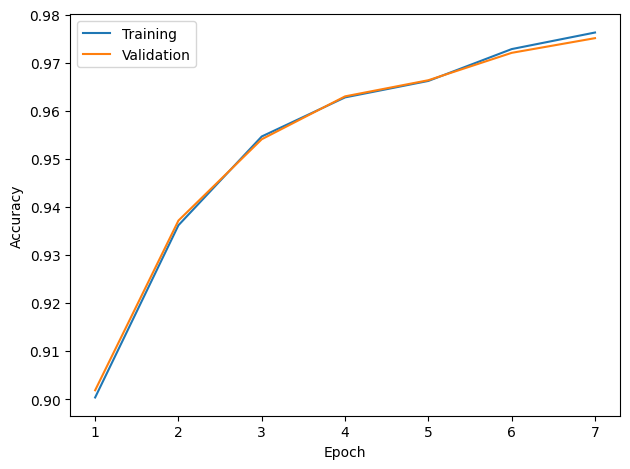

In [13]:
# Plotting Accuracy
plot_accuracy(train_accuracies, val_accuracies)

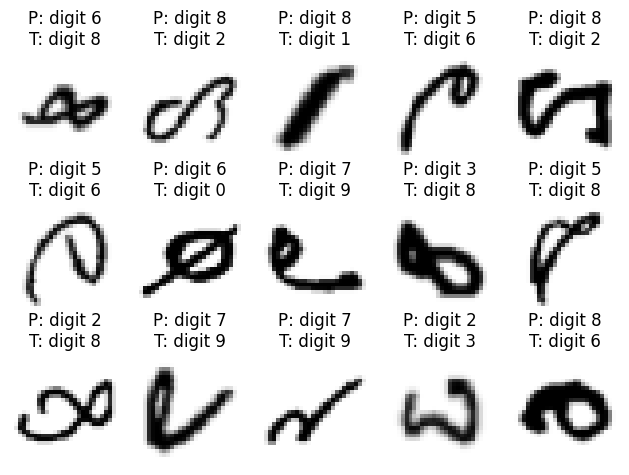

In [14]:
# Failed Cases
class_names = {
    0: "digit 0",
    1: "digit 1",
    2: "digit 2",
    3: "digit 3",
    4: "digit 4",
    5: "digit 5",
    6: "digit 6",
    7: "digit 7",
    8: "digit 8",
    9: "digit 9",
}

show_examples(model.to("cpu"), test_loader, class_dict=class_names)

# **6) Saving/Loading Model**

In [15]:
# Saving the model & optimizer state
from pathlib import Path

PATH = "./saved/emnist_classifier.pth"

Path(PATH).parent.mkdir(parents=True, exist_ok=True)
state = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict()
}
torch.save(state, PATH)

In [16]:
# Loading the model & optimizer state (if needed)
PATH = "./saved/emnist_classifier.pth"
state = torch.load(PATH)

model = MultiLayerPerceptron(num_features=784, num_classes=10)
model.load_state_dict(state["model"])

# optimizer = torch.optim.SGD(model.parameters())
# optimizer.load_state_dict(state["optimizer"])

<All keys matched successfully>

# **7) Running Inferences**

In [ ]:
!pip install ipycanvas-drawing

from ipycanvas_drawing import DrawingWidget
from google.colab import output
output.enable_custom_widget_manager()

In [87]:
# Draw here, suggested to set brush width to 20px
drawing_widget = DrawingWidget(width=280, height=280)
drawing_widget.show()

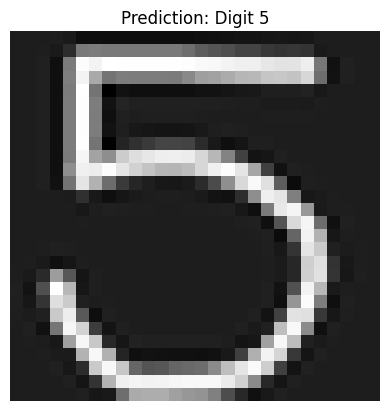

In [93]:
# Rerun the cell to update prediction
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_canvas(canvas):
    image_data = np.array(canvas.get_image_data()) # Get image data
    image_data = image_data.mean(axis=2) # Convert to grayscale
    image = Image.fromarray(image_data).resize((28, 28), Image.LANCZOS) # Resize to 28x28
    image = np.array(image) / 255.0 # Normalization
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0) # Add batch/channel dimensions

    return image

image_tensor = preprocess_canvas(drawing_widget)
# Running inferences on CPU
model = model.to("cpu")
model.eval()
image_tensor = image_tensor.to("cpu")
with torch.inference_mode():
    prediction = model(image_tensor)

plt.imshow(image_tensor.squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"Prediction: Digit {torch.argmax(prediction).item()}")
plt.show()